In [16]:
#Load the iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

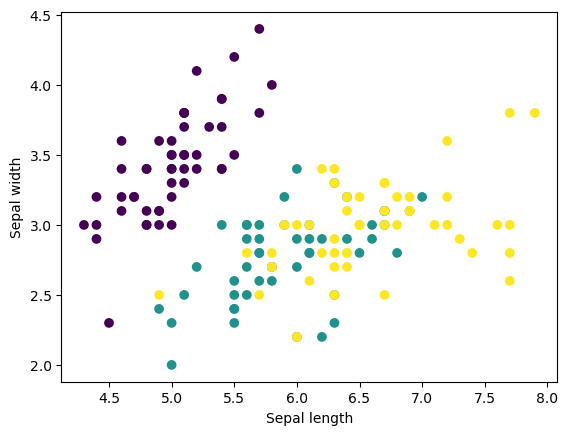

In [17]:
#Plot the data with legend
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

In [18]:
import numpy as np
from collections import defaultdict
import time
import tracemalloc

class LSH_KNN:
    def __init__(self,X,y,n_neighbors=5):
        self.X = X
        self.y = y
        self.n_hyperplanes=int(np.log2(X.shape[0]))
        self.n_neighbors =n_neighbors
        self.hyperplanes = None
        self.buckets = defaultdict(list)
        self.labels = None
    
    def fit(self):
        self.labels = self.y
        n_samples, n_features = self.X.shape
        self.hyperplanes = np.random.normal(size=(self.n_hyperplanes, n_features))
        for i in range(n_samples):
            hash_val = self.hash(self.X[i])
            self.buckets[hash_val].append(i)
    
    def predict(self, X):
        n_samples = X.shape[0]
        y_pred = []
        for i in range(n_samples):
            neighbors = self.find_nearest_neighbors(X[i])
            if len(neighbors) == 0:
            # No neighbors found, assign a random label or handle this case as needed
                y_pred.append(np.random.choice(np.unique(self.labels)))
            else:    
                neighbors = np.array(neighbors, dtype=int)
                labels = self.labels[neighbors]
                unique, counts = np.unique(labels, return_counts=True)
                y_pred.append(unique[np.argmax(counts)])
        return np.array(y_pred)
    
    def hash(self, x):
        hash_val = ""
        for i in range(self.n_hyperplanes):
            dot_product = np.dot(self.hyperplanes[i], x)
            hash_val += "1" if dot_product >= 0 else "0"
        return hash_val
    
    def find_nearest_neighbors(self, x):
        hash_val = self.hash(x)
        candidate_indices = []
        if(self.buckets[hash_val] is not None):
            candidate_indices=self.buckets[hash_val]
        candidate_indices = np.unique(candidate_indices)
        distances = [np.linalg.norm(x - X[i]) for i in candidate_indices]
        nearest_neighbors = np.argsort(distances)[:self.n_neighbors]
        return candidate_indices[nearest_neighbors]
    
    def give_hyperplanes(self):
        return self.hyperplanes

start_time = time.time()
tracemalloc.start()

lsh_knn = LSH_KNN(X,y)

lsh_knn.fit()
train_end_time = time.time()

print("Memory usage: ", tracemalloc.get_traced_memory()[1], "bytes")

tracemalloc.stop()

y_pred = lsh_knn.predict(X)

test_end_time = time.time()

print("Accuracy: ", np.mean(y_pred == y))
print("Training time: ", train_end_time - start_time)
print("Testing time: ", test_end_time - train_end_time)

Memory usage:  83358414 bytes
Accuracy:  0.9533333333333334
Training time:  0.008000373840332031
Testing time:  0.1866600513458252


**Naive KNN**

In [7]:
class naive_KNN:
    def __init__(self, k,X,y):
        self.k = k
        self.dataset = [(X[i], y[i]) for i in range(len(X))]
    def predict(self, x):
        distances = []
        for i in range(len(self.dataset)):
            distances.append((i, self.distance(x, self.dataset[i][0])))
        distances.sort(key=lambda x: x[1])
        k_nearest = distances[:self.k]
        return self.majority_vote(k_nearest)
    def k_nearest(self, x):
        distances = []
        for i in range(len(self.dataset)):
            distances.append((i, self.distance(x, self.dataset[i][0])))
        distances.sort(key=lambda x: x[1])
        k_nearest = distances[:self.k]
        return k_nearest
    def distance(self, x1, x2):
        return sum((x1[i] - x2[i])**2 for i in range(len(x1)))**0.5
    def majority_vote(self, k_nearest):
        votes = {}
        for i in range(len(k_nearest)):
            label = self.dataset[k_nearest[i][0]][1]
            if label in votes:
                votes[label] += 1
            else:
                votes[label] = 1
        return max(votes, key=votes.get)
    def score(self, test_data):
        correct = 0
        for x, y in test_data:
            if self.predict(x) == y:
                correct += 1
        return correct / len(test_data)
    

# **N=1000 and D=11** #

In [8]:
import pandas as pd

#Load the Telecommunications dataset
data = pd.read_csv('teleCust1000t.csv')
y=data['custcat']
X=data.drop(['custcat'],axis=1)
X=X.to_numpy()
y=y.to_numpy()

In [9]:
start_time = time.time()
tracemalloc.start()

lsh_knn = LSH_KNN(X,y)

lsh_knn.fit()
train_end_time = time.time()

print("Memory usage: ", tracemalloc.get_traced_memory()[1], "bytes")

tracemalloc.stop()

y_pred = lsh_knn.predict(X)

test_end_time = time.time()

print("Accuracy: ", np.mean(y_pred == y))
print("Training time: ", train_end_time - start_time)
print("Testing time: ", test_end_time - train_end_time)

Memory usage:  45537 bytes
Accuracy:  0.527
Training time:  0.03151106834411621
Testing time:  0.5287871360778809


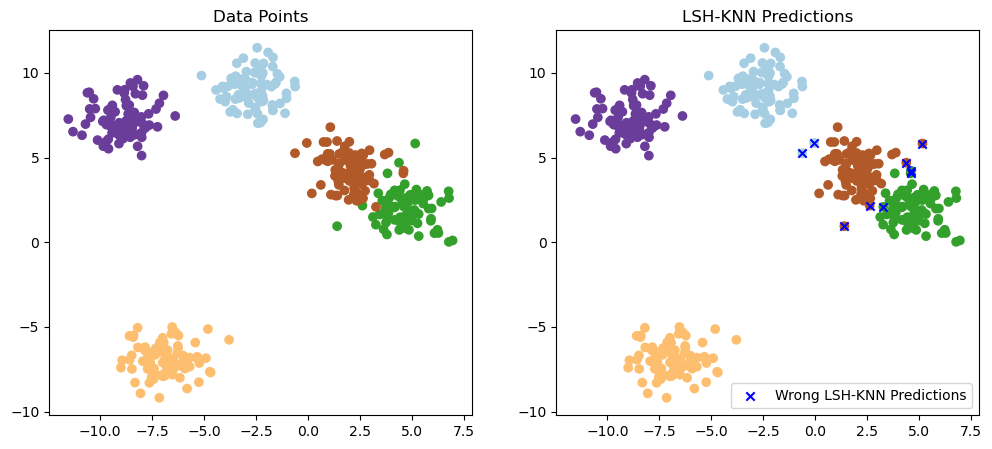

In [10]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=400, centers=5, random_state=42)

# Fit LSH-KNN model
lsh_knn = LSH_KNN(X, y)
lsh_knn.fit()
y_knn_pred = lsh_knn.predict(X) 

plt.figure(figsize=(12, 5))

# Plot for exact KNN
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.title("Data Points")

# Plot for LSH-KNN
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y_knn_pred, cmap=plt.cm.Paired)
plt.title("LSH-KNN Predictions")


wrong_lsh = X[y != y_knn_pred]
plt.scatter(wrong_lsh[:, 0], wrong_lsh[:, 1], c='blue', marker='x', label='Wrong LSH-KNN Predictions')

plt.legend()
plt.show()

In [11]:
# generate synthetic data
from sklearn.datasets import make_classification
import numpy as np
query_time=[]
memory_usage=[]
train_time=[]
for dataset_size in [100, 500,1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000, 2000000, 5000000, 10000000]:
    print("Dataset size:", dataset_size)
    X, y = make_classification(n_samples=dataset_size, n_features=100, n_informative=10, n_redundant=10, n_clusters_per_class=2)
    # naive_knn=LSH_KNN(5,X,y)
    lsh_knn = LSH_KNN(X, y)
    start_time = time.time()
    lsh_knn.fit()
    end_time = time.time()
    train_time.append(end_time - start_time)
    #select 100 points randomly foar testing
    random_indices = np.random.choice(len(X), 100, replace=False)
    test_elements = []
    for i in random_indices:
        test_elements.append(X[i])
    start_time = time.time()
    tracemalloc.start()
    lsh_knn.predict(np.array(test_elements))
    end_time = time.time()
    query_time.append(end_time - start_time)
    
    memory_usage.append(tracemalloc.get_traced_memory()[1])
    tracemalloc.stop()
    # print("Execution time for dataset size", dataset_size, ":", end_time - start_time, "s")
    # print("Accuracy for dataset size", dataset_size, ":", naive_knn.score(list(zip(X, y))), "\n")

df = pd.DataFrame({'Dataset Size': [100, 500,1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000, 2000000, 5000000, 10000000], 'Query Time': query_time, 'Memory Usage': memory_usage, 'Train Time': train_time})
print(df)

Dataset size: 100
Dataset size: 500
Dataset size: 1000
Dataset size: 2000
Dataset size: 5000
Dataset size: 10000
Dataset size: 20000
Dataset size: 50000
Dataset size: 100000
Dataset size: 200000
Dataset size: 500000
Dataset size: 1000000
Dataset size: 2000000
Dataset size: 5000000
Dataset size: 10000000
    Dataset Size  Query Time  Memory Usage  Train Time
0            100    0.013998         90730    0.000999
1            500    0.014503         90797    0.004007
2           1000    0.013017         90646    0.008994
3           2000    0.017986         93175    0.019000
4           5000    0.016891         91341    0.057064
5          10000    0.015999         92798    0.127126
6          20000    0.023082         97543    0.268556
7          50000    0.022346         93120    0.691211
8         100000    0.029040         98961    1.567373
9         200000    0.032512        111254    3.452145
10        500000    0.049510        129227    9.391650
11       1000000    0.041239       

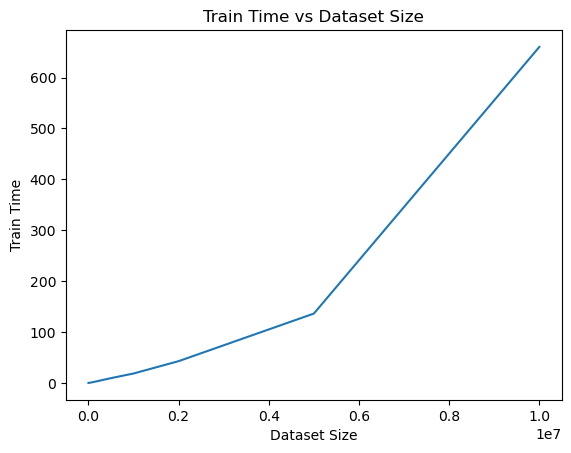

In [12]:
#plot graph for train time vs dataset size
plt.plot(df['Dataset Size'], df['Train Time'])
plt.xlabel('Dataset Size')
plt.ylabel('Train Time')
plt.title('Train Time vs Dataset Size')
plt.show()

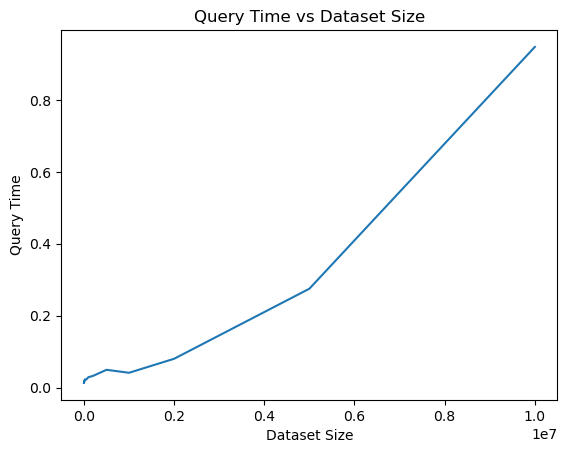

In [13]:
#plot graph for query time vs dataset size
plt.plot(df['Dataset Size'], df['Query Time'])
plt.xlabel('Dataset Size')
plt.ylabel('Query Time')
plt.title('Query Time vs Dataset Size')
plt.show()


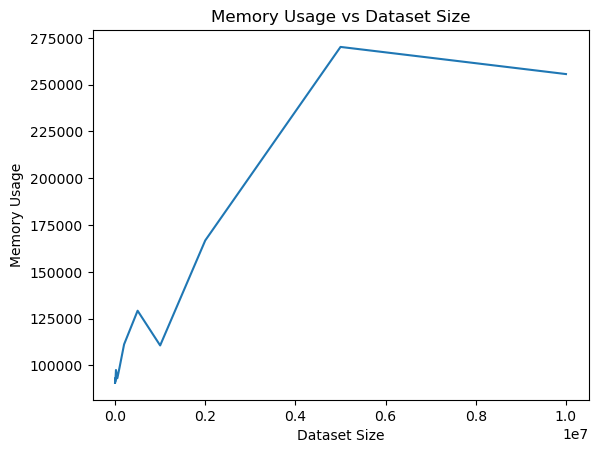

In [14]:
#plot graph for memory usage vs dataset size
plt.plot(df['Dataset Size'], df['Memory Usage'])
plt.xlabel('Dataset Size')
plt.ylabel('Memory Usage')
plt.title('Memory Usage vs Dataset Size')
plt.show()


In [23]:
# generate synthetic data
from sklearn.datasets import make_classification
import numpy as np
query_time=[]
memory_usage=[]
train_time=[]
for d in [2,5,10,20,50,100,200,500,1000,2000,5000,10000]:
    print("Dimension :", d)
    X, y = make_classification(n_samples=1000, n_features=d, n_informative=1, n_redundant=1, n_clusters_per_class=1)
    # naive_knn=LSH_KNN(5,X,y)
    lsh_knn = LSH_KNN(X, y)
    start_time = time.time()
    lsh_knn.fit()
    end_time = time.time()
    train_time.append(end_time - start_time)
    #select 100 points randomly foar testing
    random_indices = np.random.choice(len(X), 100, replace=False)
    test_elements = []
    for i in random_indices:
        test_elements.append(X[i])
    start_time = time.time()
    tracemalloc.start()
    lsh_knn.predict(np.array(test_elements))
    end_time = time.time()
    query_time.append(end_time - start_time)
    
    memory_usage.append(tracemalloc.get_traced_memory()[1])
    tracemalloc.stop()
    # print("Execution time for dataset size", dataset_size, ":", end_time - start_time, "s")
    # print("Accuracy for dataset size", dataset_size, ":", naive_knn.score(list(zip(X, y))), "\n")

df = pd.DataFrame({'Dimensions': [2,5,10,20,50,100,200,500,1000,2000,5000,10000], 'Query Time': query_time, 'Memory Usage': memory_usage, 'Train Time': train_time})
print(df)

Dimension : 2
Dimension : 5
Dimension : 10
Dimension : 20
Dimension : 50
Dimension : 100
Dimension : 200
Dimension : 500
Dimension : 1000
Dimension : 2000
Dimension : 5000
Dimension : 10000
    Dimensions  Query Time  Memory Usage  Train Time
0            2    0.389232        185959    0.009437
1            5    0.022053         16230    0.008107
2           10    0.017518         18874    0.006887
3           20    0.014022         26250    0.008519
4           50    0.015033         50102    0.008516
5          100    0.011770         90386    0.009508
6          200    0.013715        170206    0.010512
7          500    0.013020        410218    0.009509
8         1000    0.012976        813026    0.010514
9         2000    0.017040       1621142    0.015019
10        5000    0.020913       4045046    0.024540
11       10000    0.023434       8085046    0.028187


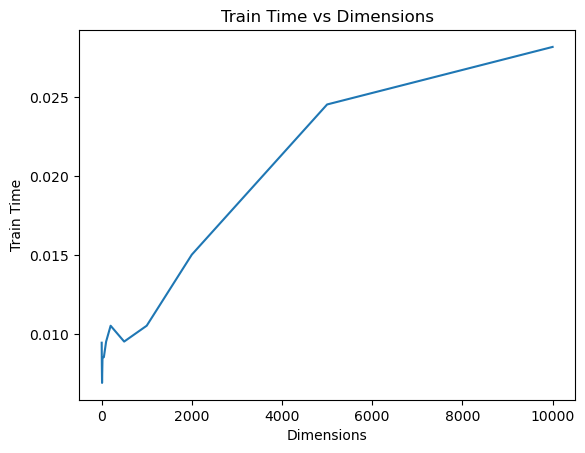

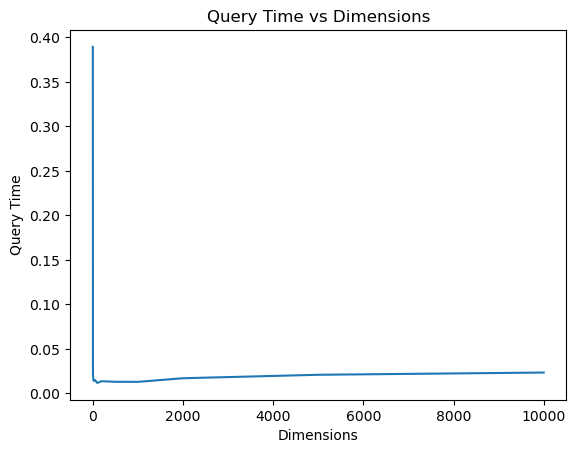

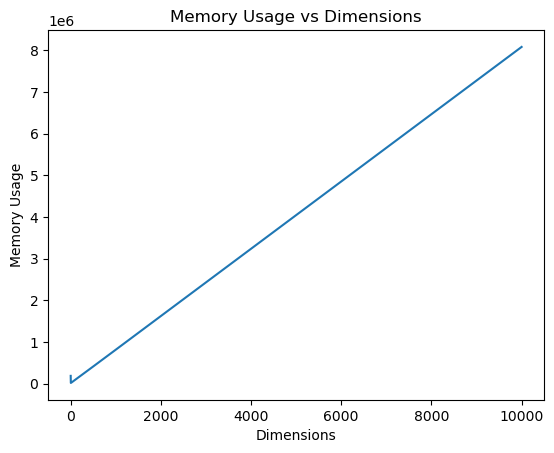

In [24]:
#plot graph for train time vs dimensions
plt.plot(df['Dimensions'], df['Train Time'])
plt.xlabel('Dimensions')
plt.ylabel('Train Time')
plt.title('Train Time vs Dimensions')
plt.show()

#plot graph for query time vs dimensions
plt.plot(df['Dimensions'], df['Query Time'])
plt.xlabel('Dimensions')
plt.ylabel('Query Time')
plt.title('Query Time vs Dimensions')
plt.show()

#plot graph for memory usage vs dimensions
plt.plot(df['Dimensions'], df['Memory Usage'])
plt.xlabel('Dimensions')
plt.ylabel('Memory Usage')
plt.title('Memory Usage vs Dimensions')
plt.show()

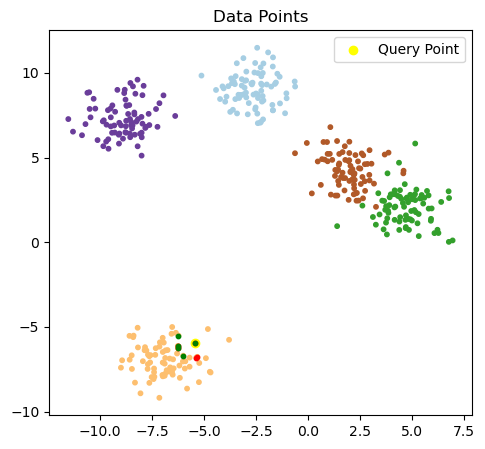

In [53]:
X, y = make_blobs(n_samples=400, centers=5, random_state=42)
i=399
naive_knn=naive_KNN(5,X,y)

dis=naive_knn.k_nearest(X[i])

lsh_knn = LSH_KNN(X, y)
lsh_knn.fit()
# y_knn_pred = lsh_knn.predict(X)
k_neigh=lsh_knn.find_nearest_neighbors(X[i])

plt.figure(figsize=(12, 5))

# Plot for exact KNN
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired,s=10)
plt.title("Data Points")


plt.scatter(X[i][0], X[i][1], c='yellow', label='Query Point')
for ind in dis:
    plt.scatter(X[ind[0]][0], X[ind[0]][1], c='red', label='',s=10)
for ind in k_neigh:
    plt.scatter(X[ind][0], X[ind][1], c='green', label='',s=10)

plt.legend()
plt.show()

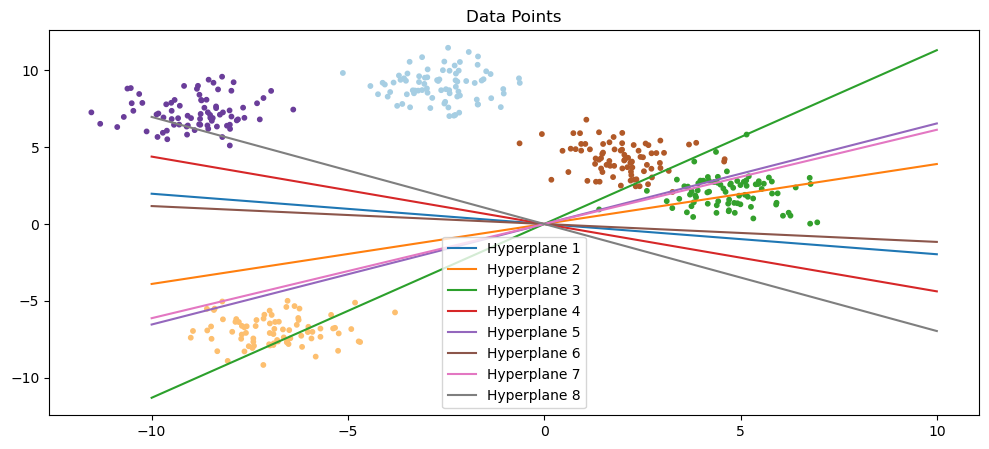

In [54]:
hyperplanes=lsh_knn.give_hyperplanes()
hyperplanes
#Plot the hyperplanes
plt.figure(figsize=(12, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired,s=10)
plt.title("Data Points")
for i in range(len(hyperplanes)):
    x = np.linspace(-10, 10, 100)
    y = (-hyperplanes[i][0] * x) / hyperplanes[i][1]
    plt.plot(x, y, label='Hyperplane '+str(i+1))
plt.legend()
plt.show()

In [55]:
print(k_neigh)
dist=[]
for i in k_neigh:
    dist.append(np.linalg.norm(X[i]-X[k_neigh[0]]))
print(dist)
print(dis)

[399 168 391 118 370]
[0.0, 0.8609522048887398, 0.8907748962379692, 0.9037907542501173, 0.968040064299105]
[(399, 0.0), (191, 0.8495035070098693), (168, 0.8609522048887398), (35, 0.8866563306586488), (391, 0.8907748962379692)]
